# **training the model** 
## Imports Librairies

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

## Imports Data

In [7]:

df_model = pd.read_csv('../Data/cleanedData.csv') 
df_model.head()
df_model.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_client                     7043 non-null   int64  
 1   genre                         7043 non-null   object 
 2   espace_client_web             7043 non-null   float64
 3   assurance_vie                 7043 non-null   object 
 4   banque_principale             7043 non-null   object 
 5   anciennete_mois               7043 non-null   float64
 6   compte_epargne                7043 non-null   object 
 7   credit_autres                 7043 non-null   object 
 8   cartes_bancaires              7043 non-null   object 
 9   compte_courant                7043 non-null   object 
 10  compte_joint                  7043 non-null   object 
 11  PEA                           7043 non-null   object 
 12  assurance_auto                7043 non-null   object 
 13  ass

## Step 1: Encode categorical columns

In [16]:
# List of categorical columns 
cat_cols = ['genre','type', 'espace_client_web', 'assurance_vie', 'banque_principale',
            'segment_client', 'methode_contact', 'compte_titres', 'branche',
            'compte_epargne', 'credit_autres', 'cartes_bancaires', 'compte_courant',
            'compte_joint', 'PEA', 'assurance_auto', 'assurance_habitation', 'credit_immo']

# Label encoding for all categorical features
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    le_dict[col] = le

# Encode target column
    target_le = LabelEncoder()
    df_model['churn'] = target_le.fit_transform(df_model['churn'])



## Step 2: Split features and target && Train/test split

In [5]:

X = df_model.drop('churn', axis=1)
y = df_model['churn']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



## Step 3: Training data With Random Forest

### Choice of Algorithm: Random Forest

Random Forest was selected as the classification algorithm for churn prediction due to
the nature of the dataset and the problem.

The dataset contains a mix of numerical and categorical variables, with potentially
non-linear relationships between customer characteristics and churn behavior.
Random Forest is well suited to capture such complex patterns without requiring
strong assumptions about data distribution or linearity.

Additionally, Random Forest is robust to noise and residual outliers, and it performs
well in situations where feature importance varies significantly across variables.
It also provides strong baseline performance with limited hyperparameter tuning,
making it an appropriate first choice for churn prediction.

In [18]:

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## Step 4: Make predictions


In [26]:

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]  # For ROC AUC


### Overall Accuracy
The model achieves **84% accuracy**, meaning it correctly predicts 85% of customers as churned or retained.  
*This is a solid starting point for a bank churn prediction model.*


In [28]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8474095102909865


## Step 5: Confusion Matrix Numbers
* **Predicted 0 (Retained):** 975 correct, 155 wrong.
    * *Note:* False positives are customers predicted as retained but actually churned.
* **Predicted 1 (Churned):** 219 correct, 60 wrong.
    * *Note:* False negatives are the critical cases: customers who actually churned but the model failed to detect.


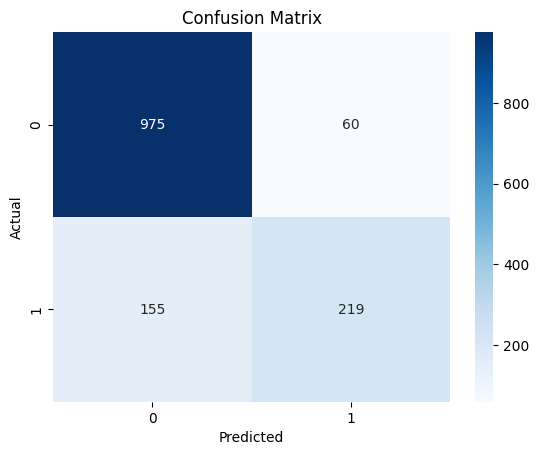

In [11]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



## Step 7 : Class-Specific Performance

**Class 0 (Retained customers)**
* **Precision = 0.86:** When the model predicts a customer is retained, it is correct 86% of the time.
* **Recall = 0.94:** The model correctly identifies 94% of all actual retained customers.
> **Observation:** The model is very good at detecting retained customers.

**Class 1 (Churned customers)**
* **Precision = 0.78:** When the model predicts a customer will churn, it is correct 78% of the time.
* **Recall = 0.59:** The model correctly identifies only 59% of all actual churned customers.
> **Observation:** The model struggles to detect all churned customers, missing 41% of them (false negatives).

**F1-Score :** 
* **Class 0 = 0.90** vs **Class 1 = 0.67**
    * Confirms that the model is more reliable for retained customers than for churned customers.
* **Averages:** Macro avg (0.79), Weighted avg (0.84).
    * Overall, the model performs reasonably well but is slightly biased towards the majority class (retained).



In [29]:
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1035
           1       0.78      0.59      0.67       374

    accuracy                           0.85      1409
   macro avg       0.82      0.76      0.79      1409
weighted avg       0.84      0.85      0.84      1409



 
### ROC AUC
* The model achieves an ROC AUC of 0.90, indicating excellent ability to distinguish between churned and retained customers. This means that, in most cases, a randomly selected churned customer will have a higher predicted probability of churn than a retained customer.


In [24]:
print("ROC AUC:", roc_auc_score(y_test, y_prob))


ROC AUC: 0.9019065333643339


### Step 8: Feature importance

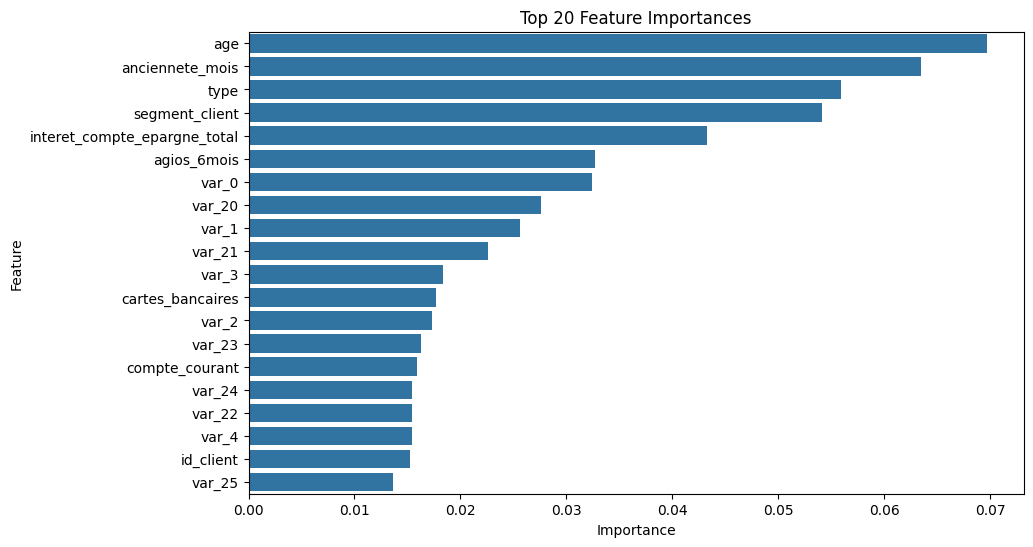

In [30]:

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances')
plt.show()

### Conclusions from the Trained Model
The trained Random Forest model predicts customer churn with 85% accuracy, a high ROC AUC of 0.90, showing strong overall discrimination between churned and retained customers, while recall for churners is lower, indicating some churned customers are missed, but the model provides a reliable baseline for further improvement.
